In [77]:
import matplotlib.pyplot as plt
from Project.visualizer.main import Visualizer
import numpy as np
from IPython.display import display, Image as IPImage
import io
from PIL import Image
import os
import tempfile

# Lokalizacja punktu w przestrzeni dwuwymiarowej- metoda trapezowa

### Treść zadania:
##### Dany jest obszar z podziałem poligonowym. Zadawany jest punkt P na płaszczyźnie. Należy zaimplementować algorytm lokalizacji punktu metodą trapezową, który odpowie na pytanie, w którym elemencie znajduje się dany punkt. (Należy także umożliwić użytkownikowi odpowiednio zadawanie obszaru z podziałem poligonowym.) Zrobić analizę efektywności algorytmu. Program powinien w sposób graficzny prezentować etapy algorytmu dla wybranych przykładów (w celu objaśnienia działania algorytmu). Program ma służyć jako narzędzie dydaktyczne do objaśnienia działania algorytmu.


## 1. Struktury danych

1.1. Punkt

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __gt__(self, other):
        return self.x >other.x

    def __hash__(self):
        return hash((self.x,self.y))

1.2. Odcinek

In [3]:
class Section:
    def __init__(self, left_end, right_end):

        self.L = left_end
        self.R = right_end

        if self.L.x == self.R.x: self.a, self.b = None, None
        else: 
            self.a = (self.R.y - self.L.y) / (self.R.x - self.L.x)
            self.b = self.L.y - self.a * self.L.x
        
    
    def __hash__(self):
        return hash((self.L, self.R))
    
    def above_point(self,point):
        if not self.a or not self.b: return None
        return self.a * point.x + self.b > point.y
    
    def get_point_at_x(self, x):
        # Przypadek pionowy: odcinek ma stałe x
        if self.a is None:
            # zwróć punkt tylko jeśli x = stałe L.x
            if x == self.L.x:
                # zwróć punkt z przedziału [L.y, R.y]
                return Point(x, self.L.y)
            else:
                return None

        # Normalny przypadek
        y = self.a * x + self.b

        # sprawdź czy punkt jest na odcinku w zakresie x
        if min(self.L.x, self.R.x) <= x <= max(self.L.x, self.R.x):
            return Point(x, y)
        else:
            return None

1.3. Trapez

In [4]:
class Trapezoid:
    def __init__(self, top, bottom, left_point, right_point):
        self.top = top
        self.bottom = bottom
        self.left_p = left_point
        self.right_p = right_point

        self.right_upper_neighbour = None
        self.right_lower_neighbour = None
        self.left_lower_neighbour = None
        self.left_upper_neighbour = None
        
        self.leaf = None

1.4. Struktura przeszukiwań- drzewo i węzły

In [5]:
class SearchGraph:
    def __init__(self, root):
        self.root=root

    def find(self, node, point, segment=None):

        if node.type == 'leaf': return node.label
        
        elif node.type == 'xnode':
            if point < node.label: return self.find(node.left, point, segment)
            else: return self.find(node.right, point, segment)

        else:
            if node.label.above_point(point): return self.find(node.right, point, segment)

            elif segment and node.label.get_point_at_x(segment.L.x) == point:
                if segment.a > node.label.a: return self.find(node.left,point,segment)
                else: return self.find(node.right,point,segment)

            else: return self.find(node.left,point,segment) 
        

class Node:
    def __init__(self, type, label):
        self.type = type
        self.label = label
        self.left = None
        self.right = None

## 2. Funkcje do wizualizacji

In [6]:
def to_xy(section):
    return ((section.L.x, section.L.y), (section.R.x, section.R.y))

2.1. Rysowanie ramki

In [7]:
def draw_frame(frame, vis):
    left_side = Section(frame.left_p, Point(frame.left_p.x, frame.right_p.y))
    right_side = Section(frame.right_p, Point(frame.right_p.x, frame.left_p.y))
    top_side = frame.bottom
    bottom_side = frame.top

    vis.add_line_segment((to_xy(left_side), to_xy(right_side), to_xy(top_side), to_xy(bottom_side)), color = "black")
    return vis

2.2. Rysowanie zadanego trapezu

In [54]:
def draw_trapezoid(figure, vis, color= "green"):

    # leftp, rightp
    vis.add_point(((figure.left_p.x, figure.left_p.y), (figure.right_p.x, figure.right_p.y)), color="blue")

    # horizontal sides
    upper = to_xy(figure.top)
    lower = to_xy(figure.bottom)

    # vertical sides
    lower_left = figure.bottom.get_point_at_x(figure.left_p.x)
    upper_left = figure.top.get_point_at_x(figure.left_p.x)

    if lower_left is None or upper_left is None:
        # nie rysujemy trapezu, bo jest niepoprawny geometrycznie
        return vis

    left_vertical = (to_xy (Section(lower_left, upper_left)) )

    lower_right = figure.bottom.get_point_at_x(figure.right_p.x)
    upper_right = figure.top.get_point_at_x(figure.right_p.x)

    if lower_right is None or upper_right is None: #TERAZ
        return vis

    right_vertical = (to_xy (Section (lower_right,upper_right) ) )

    vis.add_line_segment( (upper, lower, left_vertical, right_vertical) , color = color)

    return vis

2.3. Rysowanie zadanego trapezu i jego sąsiadów

In [9]:
def draw_trapezoid_with_neighbours(trapezoid,vis,neighbours):

    for neighbour in neighbours: vis.remove_figure(neighbour)

    vis = draw_trapezoid(trapezoid, vis)

    neighbours = []
    if trapezoid.left_upper_neighbour: neighbours.append(draw_trapezoid(trapezoid.left_upper_neighbour,vis,"orange"))
    if trapezoid.left_lower_neighbour: neighbours.append(draw_trapezoid(trapezoid.left_lower_neighbour,vis,"orange"))
    if trapezoid.right_lower_neighbour: neighbours.append(draw_trapezoid(trapezoid.right_lower_neighbour,vis,"orange"))
    if trapezoid.right_upper_neighbour: neighbours.append(draw_trapezoid(trapezoid.right_upper_neighbour,vis,"orange"))
        
    return vis, neighbours

2.4. Rysowanie mapy

In [10]:
def find_all_trapezoids(node,trapezoids):

    if node.type == 'leaf':
        trapezoids.append(node.label)

    else:
        find_all_trapezoids(node.left, trapezoids)
        find_all_trapezoids(node.right, trapezoids)

In [11]:
def draw_map(D,R):

    vis=Visualizer()
    vis=draw_frame(R,vis)

    trapezoids=[]
    find_all_trapezoids(D.root, trapezoids)

    for trapezoid in trapezoids: vis = draw_trapezoid(trapezoid,vis)

    return vis

## 3. Zadawanie odcinków tworzących mapę

In [16]:
%matplotlib tk

generate_sections=[]
used_x=set()
used_points=set()
current_points = []    

def on_key(event):

    if event.key == 'enter':

        if len(current_points) == 1:
            ax.set_title("Liczba dodanych punktów musi być parzysta!")
            plt.pause(1)
            ax.set_title('Aby dodać punkt- kliknij w wybranym miejscu myszką.\n Aby zakończyć- wciśnij enter.')
        else:
            ax.set_title('Odcinki zostały utworzone') 
            plt.pause(1)
            plt.close()

def onclick(event):

    global current_points

    if event.inaxes:

        ax.set_title('Aby dodać punkt- kliknij w wybranym miejscu myszką.\n Aby zakończyć- wciśnij enter.')
        x, y = event.xdata, event.ydata

        if len(current_points) == 1 and current_points[0][0] == x:
            ax.set_title("Nie wolno tworzyć pionowych odcinków!")
            plt.pause(1)
            ax.set_title('Aby dodać punkt- kliknij w wybranym miejscu myszką.\n Aby zakończyć- wciśnij enter.')

        elif x in used_x and (x,y) not in used_points:
            ax.set_title("Wierzchołki nie mogą mieć tej samej współrzędnej x,\njeśli nie są końcami połączonych odcinków!")
            plt.pause(1)
            ax.set_title('Aby dodać punkt- kliknij w wybranym miejscu myszką.\n Aby zakończyć- wciśnij enter.')
        
        else:
            used_x.add(x)
            used_points.add((x,y))
            current_points.append((x,y))

            plt.scatter(x, y, color="red")
            plt.show()

            if len(current_points)==2:

                plt.plot((current_points[-1][0], current_points[0][0]), (current_points[-1][1], current_points[0][1]), color = "red") 

                if current_points[0][0]>current_points[1][0]: current_points[0], current_points[1] = current_points[1], current_points[0]
                generate_sections.append((current_points[0],current_points[1]))
                current_points=[]


fig, ax = plt.subplots()

fig.canvas.manager.set_window_title("Generowanie zbioru odcinków")
ax.set_title('Aby dodać punkt- kliknij w wybranym miejscu myszką.\n Aby zakończyć- wciśnij enter.')

cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
cid_key = fig.canvas.mpl_connect('key_press_event', on_key)

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.show()

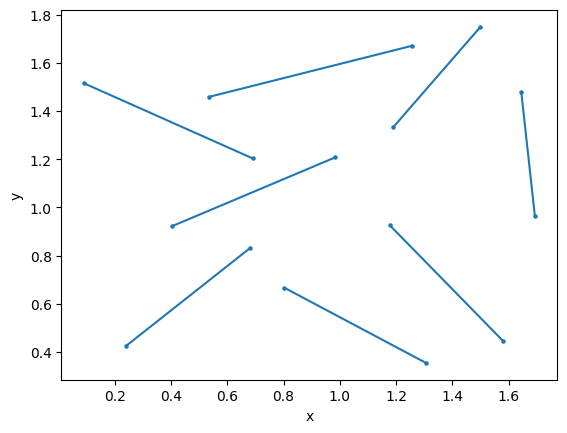

In [17]:
%matplotlib inline

vis=Visualizer()
vis.add_line_segment(generate_sections)
vis.add_point([generate_sections[i][0] for i in range(len(generate_sections))]+[generate_sections[i][1] for i in range(len(generate_sections))], s=5)
vis.show()

## 4. Tworzenie mapy i struktury przeszukiwań

In [18]:
def find_boundaries(sections):

    left_x = sections[0].L.x
    left_y = min(sections[0].L.y, sections[0].R.y)
    right_x = sections[0].R.x
    right_y = max(sections[0].L.y, sections[0].R.y)

    for i in range(1,len(sections)):
        left_x = min(left_x, sections[i].L.x)
        left_y = min(left_y, sections[i].L.y, sections[i].R.y)
        right_x = max(right_x, sections[i].R.x)
        right_y = max(right_y, sections[i].L.y, sections[i].R.y)
        
    return Point(left_x, left_y), Point(right_x, right_y)

In [19]:
def create_frame(sections):

    lower_left, upper_right = find_boundaries(sections)
    top = Section(Point(lower_left.x, upper_right.y), upper_right)
    bottom = Section(lower_left, Point(upper_right.x, lower_left.y))

    return Trapezoid(top, bottom, lower_left, upper_right)

In [20]:
def find_intersected_trapezoids(D, section):

    vis=Visualizer()

    result = [D.find(D.root, section.L, section)]

    #vis,neighbours=draw_trapezoid_with_neighbours(result[0],vis,[])
    #vis.add_line_segment(to_xy(section),color="red")
    #vis=draw_grid(frame,vis)
    #vis.show()

    i = 0
    while section.R > result[i].right_p:

        current = result[i]

        if section.above_point(current.right_p): result.append(current.right_upper_neighbour)
        else: result.append(current.right_lower_neighbour)

        i += 1
        
        #vis,neighbours=draw_trapezoid_with_neighbours(current,vis,neighbours)
        #vis.show()

    return result

In [21]:
def UXYZ(OLD_NODE, section, NEW_LEFT, NEW_TOP, NEW_BOTTOM, NEW_RIGHT):
    # zamieniamy node będący usuwanym trapezem na XNode z lewym końcem wstawianego odcinka
    OLD_NODE.type = 'xnode'
    OLD_NODE.label = section.L

    # OLD_NODE = XNode(section.L)

    # dodajemy NEW_LEFT jako node Leaf po lewej od OLD_NODE
    U = Node('leaf', NEW_LEFT)
    OLD_NODE.left = U
    NEW_LEFT.leaf = U

    # U = Leaf(NEW_LEFT)

    # dodajemy prawy koniec odcinka jako XNode po prawej od OLD_NODE
    q = Node('xnode', section.R)
    OLD_NODE.right = q

    # q = YNode(secrion.R)

    # dodajemy NEW_RIGHT jako Leaf po prawej od q
    X = Node('leaf', NEW_RIGHT)
    q.right = X
    NEW_RIGHT.leaf = X

    # X = Leaf(NEW_RIGHT)

    # dodajemy section jako YNode po lewej od q
    s = Node('ynode', section)
    q.left = s

    # dodajemy NEW_TOP jako Leaf po lewej od s
    Y = Node('leaf', NEW_TOP)
    s.left = Y
    NEW_TOP.leaf = Y

    # dodajemy NEW_BOTTOM jako Leaf po prawej od s
    Z = Node('leaf', NEW_BOTTOM)
    s.right = Z
    NEW_BOTTOM.leaf = Z

In [22]:
def UYZ(OLD_NODE, section, NEW_LEFT, NEW_TOP, NEW_BOTTOM):
    # zamieniamy node usuwanego trapezu na XNode z początkiem wstawianego odcinka
    OLD_NODE.type = 'xnode'
    OLD_NODE.label = section.L

    # wstawiamy NEW_LEFT jako Leaf po lewej
    U = Node('leaf', NEW_LEFT)
    OLD_NODE.left = U
    NEW_LEFT.leaf = U

    # wstawiamy odcinek jako YNode po prawej
    s = Node('ynode', section)
    OLD_NODE.right = s

    # wstawiamy NEW_BOTTOM jako Leaf po prawej od s
    Z = Node('leaf', NEW_BOTTOM)
    s.right = Z
    NEW_BOTTOM.leaf = Z

    # wstawiamy NEW_TOP jako Leaf po lewej od s
    Y = Node('leaf', NEW_TOP)
    s.left = Y 
    NEW_TOP.leaf = Y


In [23]:
def YZX(OLD_NODE, section, NEW_TOP, NEW_BOTTOM, NEW_RIGHT):
    # zamieniamy node usuwanego trapezu na XNode z końcem wstawianego odcinka
    OLD_NODE.type = 'xnode'
    OLD_NODE.label = section.R

    # wstawiamy NEW_RIGHT jako Leaf po prawej
    X = Node('leaf', NEW_RIGHT)
    OLD_NODE.right = X
    NEW_RIGHT.leaf = X

    # wstawiamy odcinek jako YNode po lewej
    s = Node('ynode', section)
    OLD_NODE.left = s

    # wstawiamy NEW_TOP jako Leaf po lewej od s
    Y = Node('leaf', NEW_TOP)
    s.left = Y
    NEW_TOP.leaf = Y

    # wstawiamy NEW_BOTTOM jako Leaf po prawej od s
    Z = Node('leaf', NEW_BOTTOM)
    s.right = Z
    NEW_BOTTOM.leaf = Z

In [24]:
def YZ(OLD_NODE, section, NEW_TOP, NEW_BOTTOM):
    # zamieniamy node będący usuwanym trapezem na YNode ze wstawianym odcinkiem
    OLD_NODE.type = 'ynode'
    OLD_NODE.label = section

    # po lewej od niego wstawiamy TOP jako Leaf
    Y = Node('leaf', NEW_TOP)
    OLD_NODE.left = Y
    NEW_TOP.leaf = Y

    # po prawej stawiamy BOTTOM jako Leaf
    Z = Node('leaf', NEW_BOTTOM)
    OLD_NODE.right = Z
    NEW_BOTTOM.leaf = Z

In [25]:
def handle_first(trapezoid, OLD_LOWER_LEFT, OLD_UPPER_LEFT, OLD_UPPER_RIGHT, OLD_LOWER_RIGHT, s, NEW_TOP, NEW_BOTTOM, NEW_LEFT, trapezoids = None):
     # czy wstawiamy trapez po lewej
    if trapezoid.left_p < s.L:
        NEW_LEFT = Trapezoid(trapezoid.top, trapezoid.bottom, trapezoid.left_p, s.L)

        NEW_LEFT.left_lower_neighbour = OLD_LOWER_LEFT
        if OLD_LOWER_LEFT: OLD_LOWER_LEFT.right_lower_neighbour = NEW_LEFT
        
        NEW_LEFT.left_upper_neighbour=OLD_UPPER_LEFT
        if OLD_UPPER_LEFT: OLD_UPPER_LEFT.right_upper_neighbour = NEW_LEFT

        NEW_TOP.left_upper_neighbour=NEW_LEFT
        NEW_LEFT.right_upper_neighbour=NEW_TOP

        NEW_BOTTOM.left_lower_neighbour=NEW_LEFT
        NEW_LEFT.right_lower_neighbour=NEW_BOTTOM

    else:
        # nie dodajemy trapezu po lewej
        # trzeba sprawdzać, czy wstawiany odcinek lezy ponizej czy powyzej leftp usuwanego trapezu

        NEW_BOTTOM.left_lower_neighbour = OLD_LOWER_LEFT
        NEW_TOP.left_upper_neighbour = OLD_UPPER_LEFT

        if OLD_UPPER_LEFT:
            OLD_UPPER_LEFT.right_upper_neighbour = NEW_TOP

            if s.above_point(trapezoid.left_p):
                OLD_UPPER_LEFT.right_lower_neighbour = NEW_BOTTOM
                NEW_BOTTOM.left_upper_neighbour = OLD_UPPER_LEFT

        if OLD_LOWER_LEFT:
            OLD_LOWER_LEFT.right_lower_neighbour = NEW_BOTTOM

            if not s.above_point(trapezoid.left_p):
                OLD_LOWER_LEFT.right_upper_neighbour = NEW_TOP
                NEW_TOP.left_lower_neighbour = OLD_LOWER_LEFT

    if trapezoids:
        if trapezoids[1] == trapezoid.right_lower_neighbour:
            NEW_TOP.right_upper_neighbour=OLD_UPPER_RIGHT
            if OLD_UPPER_RIGHT:
                OLD_UPPER_RIGHT.left_upper_neighbour=NEW_TOP
        else:
            NEW_BOTTOM.right_lower_neighbour=OLD_LOWER_RIGHT
            if OLD_LOWER_RIGHT:
                OLD_LOWER_RIGHT.left_lower_neighbour=NEW_BOTTOM

    return NEW_LEFT

In [26]:
def handle_last(trapezoid, OLD_LOWER_LEFT, OLD_UPPER_LEFT, OLD_UPPER_RIGHT, OLD_LOWER_RIGHT, section, NEW_TOP, NEW_BOTTOM, NEW_RIGHT, trapezoids = None):
        # czy wstawiamy trapez po po prawej
    if trapezoid.right_p > section.R:
        NEW_RIGHT = Trapezoid(trapezoid.top, trapezoid.bottom, section.R, trapezoid.right_p)

        NEW_RIGHT.right_lower_neighbour = OLD_LOWER_RIGHT
        if OLD_LOWER_RIGHT: OLD_LOWER_RIGHT.left_lower_neighbour = NEW_RIGHT

        NEW_RIGHT.right_upper_neighbour=OLD_UPPER_RIGHT
        if OLD_UPPER_RIGHT: OLD_UPPER_RIGHT.left_upper_neighbour=NEW_RIGHT

        NEW_RIGHT.left_lower_neighbour = NEW_BOTTOM
        NEW_BOTTOM.right_lower_neighbour = NEW_RIGHT

        NEW_RIGHT.left_upper_neighbour = NEW_TOP
        NEW_TOP.right_upper_neighbour = NEW_RIGHT

    else:

        NEW_BOTTOM.right_lower_neighbour = OLD_LOWER_RIGHT
        NEW_TOP.right_upper_neighbour = OLD_UPPER_RIGHT

        if OLD_UPPER_RIGHT:
            OLD_UPPER_RIGHT.left_upper_neighbour = NEW_TOP

            if section.above_point(trapezoid.right_p):
                OLD_UPPER_RIGHT.left_lower_neighbour = NEW_BOTTOM
                NEW_BOTTOM.right_upper_neighbour = OLD_UPPER_RIGHT

        if OLD_LOWER_RIGHT:
            OLD_LOWER_RIGHT.left_lower_neighbour = NEW_BOTTOM

            if not section.above_point(trapezoid.right_p):
                OLD_LOWER_RIGHT.left_upper_neighbour = NEW_TOP
                NEW_TOP.right_lower_neighbour = OLD_LOWER_RIGHT

    if trapezoids:
        n = len(trapezoids)

        if trapezoids[n-1]==trapezoids[n-2].right_upper_neighbour:
            NEW_BOTTOM.left_lower_neighbour=OLD_LOWER_LEFT
            if OLD_LOWER_LEFT:
                OLD_LOWER_LEFT.right_lower_neighbour=NEW_BOTTOM
        else:
            NEW_TOP.left_upper_neighbour=OLD_UPPER_LEFT
            if OLD_UPPER_LEFT:
                OLD_UPPER_LEFT.right_upper_neighbour=NEW_TOP

    return NEW_RIGHT

In [27]:
def insert_into_one_trapezoid(trapezoid, section):

    NEW_LEFT = None
    NEW_TOP = Trapezoid(trapezoid.top, section, section.L, section.R)
    NEW_BOTTOM = Trapezoid(section, trapezoid.bottom, section.L, section.R)
    NEW_RIGHT = None

    OLD_LOWER_LEFT = trapezoid.left_lower_neighbour
    OLD_UPPER_LEFT = trapezoid.left_upper_neighbour
    OLD_UPPER_RIGHT = trapezoid.right_upper_neighbour
    OLD_LOWER_RIGHT = trapezoid.right_lower_neighbour

    # czy wstawiamy trapez po lewej
    NEW_LEFT = handle_first(trapezoid, OLD_LOWER_LEFT, OLD_UPPER_LEFT, OLD_UPPER_RIGHT, OLD_LOWER_RIGHT, section, NEW_TOP, NEW_BOTTOM, NEW_LEFT)

    NEW_RIGHT = handle_last(trapezoid, OLD_LOWER_LEFT, OLD_UPPER_LEFT, OLD_UPPER_RIGHT, OLD_LOWER_RIGHT, section, NEW_TOP, NEW_BOTTOM, NEW_RIGHT)



    # uaktualnienie grafu przeszukiwań
    OLD_NODE = trapezoid.leaf


    if NEW_LEFT and NEW_RIGHT:  # UYZX
        UXYZ(OLD_NODE, section, NEW_LEFT, NEW_TOP, NEW_BOTTOM, NEW_RIGHT)
       
    elif NEW_LEFT and not NEW_RIGHT:    # UYZ
        UYZ(OLD_NODE, section, NEW_LEFT, NEW_TOP, NEW_BOTTOM)


    elif not NEW_LEFT and NEW_RIGHT:    # YZX
        YZX(OLD_NODE, section, NEW_TOP, NEW_BOTTOM, NEW_RIGHT)

    else: # YZ
        YZ(OLD_NODE, section, NEW_TOP, NEW_BOTTOM)


In [28]:
def insert_into_many_trapezoids(trapezoids, s):

    NEW_LEFT,NEW_RIGHT=None,None
    new_trapezoids_above=[]
    new_trapezoids_below=[]

    n=len(trapezoids)

    first=trapezoids[0]

    # czy odcinek przechodzi z analizowanego trapezu do jego górnego sąsiada
    if s.above_point(first.right_p):
        NEW_TOP = Trapezoid(first.top, s, s.L, s.get_point_at_x(first.right_p.x)) # ostatni element to przecięcie s z prawym bokiem trapezoid
        NEW_BOTTOM = Trapezoid(s, first.bottom, s.L, first.right_p)
        merging = "below"
    else:
        NEW_TOP = Trapezoid(first.top, s, s.L, first.right_p)
        NEW_BOTTOM = Trapezoid(s, first.bottom, s.L, s.get_point_at_x(first.right_p.x))
        merging = "above"

    new_trapezoids_above.append(NEW_TOP)
    new_trapezoids_below.append(NEW_BOTTOM)

    OLD_LOWER_LEFT=first.left_lower_neighbour
    OLD_UPPER_LEFT=first.left_upper_neighbour
    OLD_UPPER_RIGHT=first.right_upper_neighbour
    OLD_LOWER_RIGHT=first.right_lower_neighbour

    NEW_LEFT = handle_first(first, OLD_LOWER_LEFT, OLD_UPPER_LEFT, OLD_UPPER_RIGHT, OLD_LOWER_RIGHT, s, NEW_TOP, NEW_BOTTOM, NEW_LEFT, trapezoids)



    for j in range(1, len(trapezoids)-1):

        current = trapezoids[j]

        OLD_LOWER_LEFT = current.left_lower_neighbour
        OLD_UPPER_LEFT = current.left_upper_neighbour
        OLD_UPPER_RIGHT = current.right_upper_neighbour
        OLD_LOWER_RIGHT = current.right_lower_neighbour


        # czy odcinek przechodzi do górnego sąsiada aktualnego trapezu
        if s.above_point(current.right_p):

            # znajdź punkt przecięcia odcinka z prawym bokiem akturalnego trapezu
            new_right_p = s.get_point_at_x(current.right_p.x)
            
            # mergujemy górę, tworzymy trapez dolny
            # wcześniej przechodziliśmy do górnego sąsiada
            if merging == "below":
                NEW_TOP.right_p = new_right_p

                NEXT_BOTTOM = Trapezoid(s, current.bottom, NEW_BOTTOM.right_p, current.right_p)

                NEW_BOTTOM.right_upper_neighbour = NEXT_BOTTOM
                NEXT_BOTTOM.left_upper_neighbour = NEW_BOTTOM
                NEXT_BOTTOM.left_lower_neighbour = OLD_LOWER_LEFT
                if OLD_LOWER_LEFT: OLD_LOWER_LEFT.right_lower_neighbour = NEXT_BOTTOM
                NEXT_BOTTOM.right_lower_neighbour=OLD_LOWER_RIGHT
                if OLD_LOWER_RIGHT: OLD_LOWER_RIGHT.left_lower_neighbour = NEXT_BOTTOM

                NEW_BOTTOM = NEXT_BOTTOM
                new_trapezoids_below.append(NEW_BOTTOM)

            # mergujemy dół, tworzymy trapez nad aktualnym
            # wcześniej przechodziliśmy do dolnego sąsiada
            else:
                NEW_BOTTOM.right_p = current.right_p

                NEXT_TOP = Trapezoid(current.top, s, NEW_TOP.right_p, new_right_p)

                NEW_TOP.right_lower_neighbour = NEXT_TOP
                NEXT_TOP.left_lower_neighbour = NEW_TOP
                NEXT_TOP.left_upper_neighbour=OLD_UPPER_LEFT
                if OLD_UPPER_LEFT: OLD_UPPER_LEFT.right_upper_neighbour=NEXT_TOP
                
                NEW_BOTTOM.right_lower_neighbour=OLD_LOWER_RIGHT
                if OLD_LOWER_RIGHT: OLD_LOWER_RIGHT.left_lower_neighbour=NEXT_TOP
                #NEXT_TOP.right_upper_neighbour=OLD_UPPER_RIGHT
                #if OLD_UPPER_RIGHT: OLD_UPPER_RIGHT.left_upper_neighbour = NEXT_TOP

                NEW_TOP=NEXT_TOP
                new_trapezoids_above.append(NEW_TOP)

            merging="below"


        # odcinek przechodzi do dolnego sąsiada aktualnego trapezu
        else:
            new_right_p = s.get_point_at_x(current.right_p.x)

            # mergujemy górę, tworzymy trapez dolny
            # wcześniej przechodziliśmy do górnego sąsiada
            if merging=="below":

                NEW_TOP.right_p = current.right_p

                NEXT_BOTTOM = Trapezoid(s, current.bottom, NEW_BOTTOM.right_p, new_right_p)

                NEW_BOTTOM.right_upper_neighbour = NEXT_BOTTOM
                NEXT_BOTTOM.left_upper_neighbour = NEW_BOTTOM
                NEXT_BOTTOM.left_lower_neighbour = OLD_LOWER_LEFT
                if OLD_LOWER_LEFT: OLD_LOWER_LEFT.right_lower_neighbour = NEXT_BOTTOM

                NEW_TOP.right_upper_neighbour=OLD_UPPER_RIGHT
                if OLD_UPPER_RIGHT: OLD_UPPER_RIGHT.left_upper_neighbour=NEW_TOP
                #NEXT_BOTTOM.right_lower_neighbour=OLD_LOWER_RIGHT
                #if OLD_LOWER_RIGHT: OLD_LOWER_RIGHT.left_lower_neighbour = NEXT_BOTTOM

                NEW_BOTTOM = NEXT_BOTTOM
                new_trapezoids_below.append(NEW_BOTTOM)

            else:
                NEW_BOTTOM.right_p = new_right_p

                NEXT_TOP = Trapezoid(current.top, s, NEW_TOP.right_p, current.right_p)

                NEW_TOP.right_lower_neighbour = NEXT_TOP
                NEXT_TOP.left_lower_neighbour = NEW_TOP
                NEXT_TOP.left_upper_neighbour = OLD_UPPER_LEFT
                if OLD_UPPER_LEFT: OLD_UPPER_LEFT.right_upper_neighbour = NEXT_TOP
                NEXT_TOP.right_upper_neighbour=OLD_UPPER_RIGHT
                if OLD_UPPER_RIGHT: OLD_UPPER_RIGHT.left_upper_neighbour = NEXT_TOP

                NEW_TOP = NEXT_TOP
                new_trapezoids_above.append(NEW_TOP)

            merging="above"



    last=trapezoids[n-1]

    OLD_LOWER_LEFT=last.left_lower_neighbour
    OLD_UPPER_LEFT=last.left_upper_neighbour
    OLD_UPPER_RIGHT=last.right_upper_neighbour
    OLD_LOWER_RIGHT=last.right_lower_neighbour

    if merging == "below":
        NEW_TOP.right_p = s.R

        NEXT_BOTTOM = Trapezoid(s, last.bottom, NEW_BOTTOM.right_p, s.R)

        NEW_BOTTOM.right_upper_neighbour = NEXT_BOTTOM
        NEXT_BOTTOM.left_upper_neighbour = NEW_BOTTOM

        NEW_BOTTOM = NEXT_BOTTOM
        new_trapezoids_below.append(NEW_BOTTOM)

    else:
        NEW_BOTTOM.right_p = s.R 

        NEXT_TOP = Trapezoid(last.top, s, NEW_TOP.right_p, s.R)

        NEW_TOP.right_lower_neighbour = NEXT_TOP
        NEXT_TOP.left_lower_neighbour = NEW_TOP

        NEW_TOP = NEXT_TOP
        new_trapezoids_above.append(NEW_TOP)

    NEW_RIGHT = handle_last(last, OLD_LOWER_LEFT, OLD_UPPER_LEFT, OLD_UPPER_RIGHT, OLD_LOWER_RIGHT, s, NEW_TOP, NEW_BOTTOM, NEW_RIGHT, trapezoids)


    # UAKTUALNIENIE DRZEWA PRZESZUKIWAŃ


    # 1. DODANIE PIERWSZEGO TRAPEZU
    first_node = first.leaf
    if NEW_LEFT: UYZ(first_node, s, NEW_LEFT, new_trapezoids_above[0], new_trapezoids_below[0])
    else: YZ(first_node, s, new_trapezoids_above[0], new_trapezoids_below[0])

    # 2. DODANIE ŚRODKOWYCH TRAPEZÓW
    i=0
    j=0
    k=len(new_trapezoids_above)
    m=len(new_trapezoids_below)
    while i+j<n-2:
        node=trapezoids[i+j+1].leaf
        node.type='ynode'
        node.label=s

        # jeśli aktualny górny kończy się dalej, niz aktualny dolny (lub doszliśmy do końca górnych): dodaj połączenie do górnego po lewej i następny dolny po prawej
        if new_trapezoids_above[i].right_p > new_trapezoids_below[j].right_p or i==k-1:

            Y = new_trapezoids_above[i].leaf
            node.left = Y

            j+=1
            Z = Node('leaf',new_trapezoids_below[j])
            node.right = Z
            new_trapezoids_below[j].leaf = Z

        # jeśli dolny kończy się dalej niz aktualny górny: dodaj następny górny po lewej i połączenie do dolnego po prawej
        else:

            i+=1
            Y = Node('leaf',new_trapezoids_above[i])
            node.left = Y
            new_trapezoids_above[i].leaf = Y

            Z = new_trapezoids_below[j].leaf
            node.right = Z
            

    # 3. DODANIE OSTATNIEGO TRAPEZU
    last_node = last.leaf

    if NEW_RIGHT: # YZX

        last_node.type = 'xnode'
        last_node.label = s.R

        X = Node('leaf', NEW_RIGHT)
        last_node.right = X
        NEW_RIGHT.leaf = X

        s = Node('ynode',s)
        last_node.left = s

        if i==k-1 and j==m-1:
            s.left = new_trapezoids_above[i].leaf
            s.right = new_trapezoids_below[j].leaf

        elif j==m-1:
            Y = Node('leaf', new_trapezoids_above[-1])
            s.left= Y
            new_trapezoids_above[-1].leaf= Y
            s.right = new_trapezoids_below[j].leaf

        else:
            Z = Node('leaf', new_trapezoids_below[-1])
            s.right = Z
            new_trapezoids_below[-1].leaf = Z 
            s.left = new_trapezoids_above[i].leaf

    else: #YZ
        last_node.type=  'ynode'
        last_node.label=s

        if i==k-1 and j==m-1:
            last_node.left=new_trapezoids_above[i].leaf
            last_node.right=new_trapezoids_below[j].leaf
        elif j==m-1:
            Y = Node('leaf',new_trapezoids_above[-1])
            last_node.left = Y
            new_trapezoids_above[-1].leaf = Y
            last_node.right = new_trapezoids_below[j].leaf
        else:
            Z = Node('leaf', new_trapezoids_below[-1])
            last_node.right = Z
            new_trapezoids_below[-1].leaf = Z
            last_node.left = new_trapezoids_above[i].leaf

In [95]:
def trapezoidal_map(S):

    frame = create_frame(S)
    T = frame
    root = Node('leaf', T)
    T.leaf = root
    D = SearchGraph(root)

    sections = np.random.permutation(S)

    image_paths = []

    temp_dir = tempfile.mkdtemp()

    vis=draw_map(D,frame)
    frame_path = os.path.join(temp_dir, f"frame_{len(image_paths):03d}.png")
    vis.save(frame_path)
    image_paths.append(frame_path)

    for section in sections:

        area_of_section = find_intersected_trapezoids(D, section)

        if len(area_of_section)==1: insert_into_one_trapezoid(area_of_section[0], section)
        else: insert_into_many_trapezoids(area_of_section,section)

        vis = draw_map(D, frame)
        frame_path = os.path.join(temp_dir, f"frame_{len(image_paths):03d}.png")
        vis.save(frame_path)
        image_paths.append(frame_path)

    images = []
    for image_path in image_paths:
        images.append(Image.open(image_path))

    gif_buffer = io.BytesIO()
    images[0].save(
        gif_buffer,
        format='GIF',
        save_all=True,
        append_images=images[1:],
        duration=1000,
        loop=0
    )
    gif_buffer.seek(0)

    display(IPImage(data=gif_buffer.getvalue(), format='gif'))

    for image_path in image_paths:
        os.remove(image_path)
    os.rmdir(temp_dir)

    return T, D, frame

In [30]:
def trapezoidal_map_without_visualizaion(S):

    frame = create_frame(S)
    T = frame
    root = Node('leaf', T)
    T.leaf = root
    D = SearchGraph(root)

    sections = np.random.permutation(S)

    for section in sections:

        area_of_section = find_intersected_trapezoids(D, section)

        if len(area_of_section)==1: insert_into_one_trapezoid(area_of_section[0], section)
        else: insert_into_many_trapezoids(area_of_section,section)

    return T,D,frame

## 5. Lokalizacja punktu na mapie

In [96]:
def draw_trapezoid_and_point(point,D,R):

    trapezoid = D.find(D.root, point)

    vis=Visualizer()
    vis.add_point((point.x,point.y),color="red")
    vis=draw_trapezoid(trapezoid,vis)
    vis=draw_frame(R,vis)             
    return vis


In [125]:
def trapezoidal_map_and_point(S, final_point, gif_filename = None):

    frame = create_frame(S)
    T = frame
    root = Node('leaf', T)
    T.leaf = root
    D = SearchGraph(root)

    sections = np.random.permutation(S)

    image_paths = []

    temp_dir = tempfile.mkdtemp()

    vis=draw_map(D,frame)
    frame_path = os.path.join(temp_dir, f"frame_{len(image_paths):03d}.png")
    vis.save(frame_path)
    image_paths.append(frame_path)

    for section in sections:

        area_of_section = find_intersected_trapezoids(D, section)

        if len(area_of_section)==1: insert_into_one_trapezoid(area_of_section[0], section)
        else: insert_into_many_trapezoids(area_of_section,section)

        vis = draw_map(D, frame)
        frame_path = os.path.join(temp_dir, f"frame_{len(image_paths):03d}.png")
        vis.save(frame_path)
        image_paths.append(frame_path)

    final_vis = draw_trapezoid_and_point(final_point, D, frame)
    final_frame_path = os.path.join(temp_dir, f"frame_{len(image_paths):03d}.png")
    final_vis.save(final_frame_path)
    image_paths.append(final_frame_path)

    images = []
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)

        if i == len(image_paths) - 1:
            images.extend([img] * 2)
        else:
            images.append(img)

    gif_buffer = io.BytesIO()
    images[0].save(
        gif_buffer,
        format='GIF',
        save_all=True,
        append_images=images[1:],
        duration=1000,
        loop=0
    )
    gif_buffer.seek(0)

    if gif_filename:
        with open(gif_filename, 'wb') as f:
            f.write(gif_buffer.getvalue())

    display(IPImage(data=gif_buffer.getvalue(), format='gif'))

    for image_path in image_paths:
        os.remove(image_path)
    os.rmdir(temp_dir)

    return T, D, frame

## 6. Testy

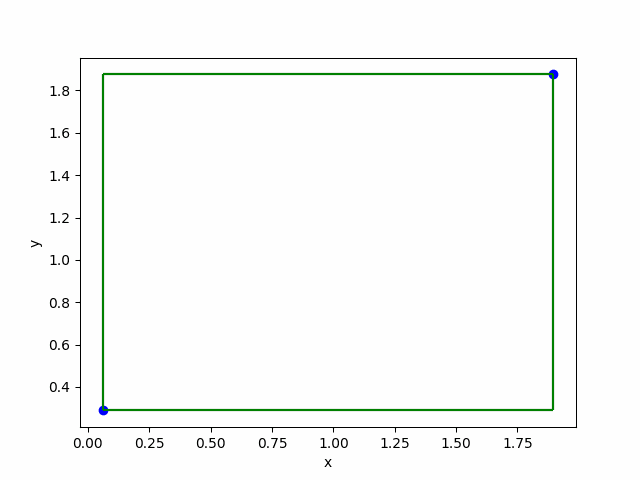

In [123]:
test_lines = [((np.float64(0.22203566103224023), np.float64(1.8755816658911117)), (np.float64(0.9870813337175937), np.float64(1.6504769660307117))), ((np.float64(0.7489067375042289), np.float64(1.519602140530479)), (np.float64(0.8679940356109113), np.float64(1.3887273150302464))), ((np.float64(0.6622977934266416), np.float64(0.9228129362494183)), (np.float64(1.896475246532259), np.float64(1.05892275476966))), ((np.float64(0.05964389088676428), np.float64(0.47783852954862716)), (np.float64(1.3984738180861327), np.float64(0.47260353652861786))), ((np.float64(1.2396907539438895), np.float64(0.7762331316891576)), (np.float64(1.8639968925031638), np.float64(0.28937878082829216)))]
S=[]
n=len(test_lines)
for i in range(n):
    left_end=Point(test_lines[i][0][0],test_lines[i][0][1])
    right_end=Point(test_lines[i][1][0],test_lines[i][1][1])
    S.append(Section(left_end,right_end))

T,D,frame=trapezoidal_map(S)

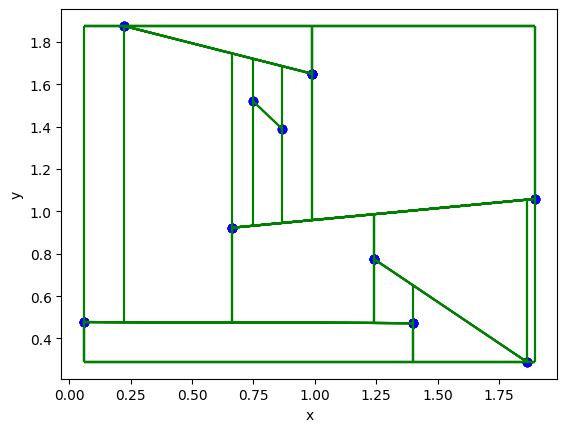

In [99]:
vis=draw_map(D,frame)
vis.show()

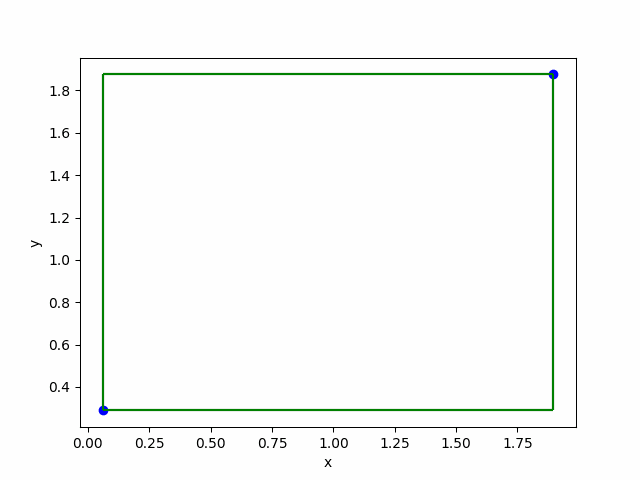

(<__main__.Trapezoid at 0x25609a3a350>,
 <__main__.Trapezoid at 0x25609a3a350>)

In [127]:
point=Point(1.0,0.6)
trapezoidal_map_and_point(S, point)

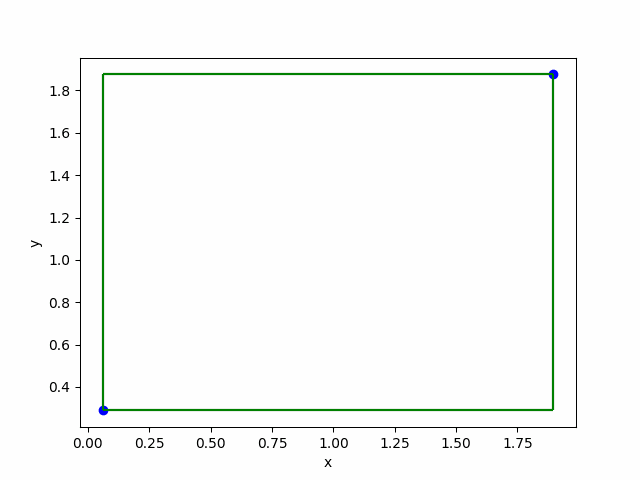

(<__main__.Trapezoid at 0x25606b91190>,
 <__main__.Trapezoid at 0x25606b91190>)

In [126]:
point2=Point(0.2,1.0)
trapezoidal_map_and_point(S, point2)

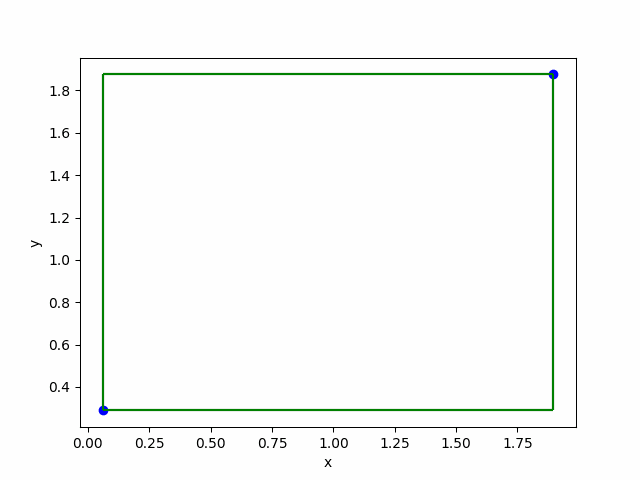

(<__main__.Trapezoid at 0x25606c7e090>,
 <__main__.Trapezoid at 0x25606c7e090>)

In [102]:
point3=Point(1.25,1.5)
trapezoidal_map_and_point(S, point3)

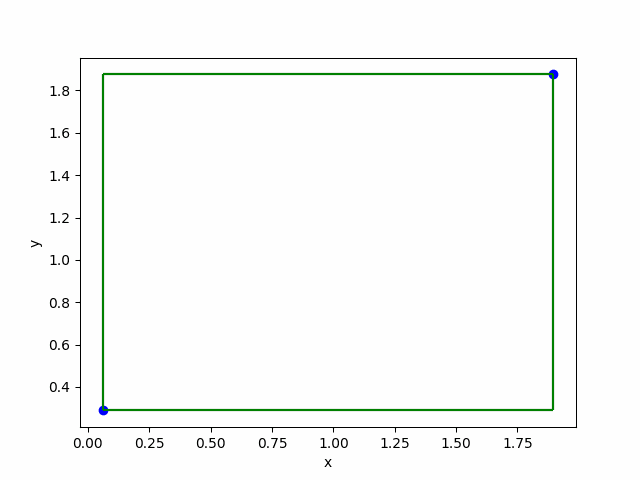

(<__main__.Trapezoid at 0x256096bcad0>,
 <__main__.Trapezoid at 0x256096bcad0>)

In [103]:
point4=Point(1.25,0.25)
trapezoidal_map_and_point(S, point4)